# 2 Classification using CNN (50 Marks)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import wandb
import yaml
from omegaconf import OmegaConf
from PIL import Image
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
import matplotlib.pyplot as plt
import random, math

# Set up wandb key
os.environ["WANDB_API_KEY"] = "c8a7a539cb5fed3df89b21d71956ca6b4befd2a5"

config = OmegaConf.load("../config.yaml")
overrides = OmegaConf.from_cli()
config = OmegaConf.merge(config, overrides)
OmegaConf.to_container(config)
config = OmegaConf.to_container(config, resolve=True)

# set up device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

torch.manual_seed(config["random_state"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["random_state"])
    torch.cuda.manual_seed_all(config["random_state"])

Using device: cpu


## 2.1 Data Loading and Preprocessing (10 Marks)

In [2]:
def get_one_hot_encoding(label: List[int], num_classes: int=10):
    encoding = torch.zeros(num_classes)
    for digit in label:
        encoding[digit] = 1
    return encoding

def parse_folder_name(folder_name: str):
    list_format = [int(d) for d in str(folder_name)]
    if config["task"] == "single_label":
        if folder_name == "0":
            return []
        else:
            return [(len(list_format))]
    elif config["task"] == "multi_label":
        if folder_name == "0":
            return []
        else:
            return list_format


def load_mnist_data(path_to_data: str):
    data = []

    for folder_name in os.listdir(path_to_data):
        folder_path = os.path.join(path_to_data, folder_name)
        if not os.path.isdir(folder_path):
            continue

        digits = parse_folder_name(folder_name)

        if config["task"] == "single_label":
            label = get_one_hot_encoding(digits, num_classes=config["slc"]["num_classes"])
        elif config["task"] == "multi_label":
            label = get_one_hot_encoding(digits, num_classes=config["mlc"]["num_classes"])

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            data.append((img_path, label))

    return data

In [4]:
class MultiMNISTDataset(Dataset):
    def __init__(self, split: str="train", transform=None):
        super(MultiMNISTDataset, self).__init__()

        self.transform = transform
        if split == "train":
            path_to_data = str(config["train_folder"])
        elif split == "val":
            path_to_data = str(config["val_folder"])
        elif split == "test":
            path_to_data = str(config["test_folder"])
        else:
            raise ValueError(f"Invalid split: {split}")
        
        self.data = load_mnist_data(path_to_data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('L') # greyscale
        if self.transform:
            image = self.transform(image)
        else: # default
            image = torch.from_numpy(np.array(image)).float() / 255.0
            image = image.unsqueeze(0) 
        
        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((config["input_size"], config["input_size"])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
    
train_dataset = MultiMNISTDataset(split="train", transform=transform)
val_dataset = MultiMNISTDataset(split="val", transform=transform)
test_dataset = MultiMNISTDataset(split="test", transform=transform)

if config["task"] == "single_label":
    train_dataloader = DataLoader(train_dataset, batch_size=config["slc"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["slc"]["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["slc"]["batch_size"], shuffle=True)
elif config["task"] == "multi_label":
    train_dataloader = DataLoader(train_dataset, batch_size=config["mlc"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["mlc"]["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["mlc"]["batch_size"], shuffle=True)



## 2.2 Implement the CNN Class (20 Marks)

In [7]:
class CNN(nn.Module):
    def __init__(
            self,
            task: str,
            label_type: str,
            lr: float=1e-4,
            dropout: float=0.1,
            n_cnn_layers: int=3,
            optimizer: str="AdamW",
            save_feature_maps: bool=False,
            input_channels: int=1,
            num_classes: int=3,
            kernel_size: int=3,
            padding: int=1
    ):
        super(CNN, self).__init__()
        self.lr = lr
        self.task = task
        self.label_type = label_type
        self.save_feature_maps = save_feature_maps
        # self.feature_maps = defaultdict(list) if save_feature_maps else None
        self.features_maps: list = []

        current_size = config["input_size"]  # Initial image size
        current_channels = input_channels
        
        self.layers = nn.ModuleList()
        
        for i in range(n_cnn_layers):
            out_channels = current_channels * 2 if i > 0 else 32
            self.layers.append(
                nn.Conv2d(
                    current_channels,
                    out_channels, 
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
            current_size = (current_size + 2 * padding - kernel_size) // 1 + 1
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU())            
            if current_size // 2 >= 1:
                self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_size //= 2
            self.layers.append(nn.Dropout(dropout))
            current_channels = out_channels
            print(f"Layer {i+1} output size: {current_size}x{current_size}, channels: {current_channels}")

        self.feature_size = current_channels * current_size * current_size
        print(f"Feature size before FC layer: {self.feature_size}")

        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        if self.task == "classification":
            if self.label_type == "multi":
                self.output_layer = nn.Sequential(
                    nn.Linear(512, num_classes),
                    nn.Sigmoid()
                )
            else:  # single
                self.output_layer = nn.Sequential(
                    nn.Linear(512, num_classes),
                    nn.Softmax(dim=1)
                )
        else:  # regression
            self.output_layer = nn.Sequential(
                nn.Linear(512, num_classes),
                nn.Identity()
            )

        if optimizer.lower() == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer.lower() == "adamw":
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=lr)
        elif optimizer.lower() == "sgd":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        elif optimizer.lower() == "adagrad":
            self.optimizer = torch.optim.Adagrad(self.parameters(), lr=lr)

        if self.task == "classification":
            if self.label_type == "single":
                self.criterion = nn.CrossEntropyLoss()
            else:  # multi
                self.criterion = nn.BCELoss()
        else:  # regression
            self.criterion = nn.MSELoss()

    def _save_feature_map(self, x: torch.Tensor, layer_name: str):
        if self.save_feature_maps:
            self.feature_maps[layer_name].append(x.detach().cpu())

    def forward(self, x: torch.Tensor):
        if self.save_feature_maps:
            self.features_maps = []
            
        # Conv layers
        for i, layer in enumerate(self.layers):
            x = layer(x)

            if i % 4 == 0 and i != 0 and self.save_feature_maps:
                self.features_maps.append(x.detach().cpu())

        # # Flatten
        x = x.view(-1, self.feature_size)
        
        # # FC layers
        x = self.fc_layers(x)
        
        # # Output layer
        x = self.output_layer(x)
        
        return x
    

In [8]:
def validate_CNN(model: CNN, val_dataloader: DataLoader, device: torch.device):
    model.eval()
    total_val_loss = 0
    
    if config["task"] == "multi_label" and model.task == "classification":
        total_em_count = 0 # exact match
        total_em_samples = 0
        total_m_count = 0 # match (not exact)
        total_m_samples = 0
        total_hamming_count = 0
    else:
        metric = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            if model.task == "classification":
                loss = model.criterion(output, target.float())
                if config["task"] == "single_label":
                    pred = output.argmax(dim=1)
                    target = target.argmax(dim=1)
                    metric += (pred == target).sum().item()
                elif config["task"] == "multi_label":
                    pred = (output > 0.5).float()
                    total_m_count += (pred == target).sum().item()
                    total_em_count += (pred == target).all(dim=1).sum().item() 
                    total_m_samples += data.size(0) * target.size(1) # 32 * 10
                    total_em_samples += data.size(0) # 32
                    total_hamming_count += ((pred != target).float().mean(dim=1).sum().item())
                    # print(f"pred: {pred}")
                    # print(f"total_m_count: {total_m_count}")
                    # print(f"total_em_count: {total_em_count}")
                    # print(f"total_m_samples: {total_m_samples}")
                    # print(f"total_em_samples: {total_em_samples}")
                    # print(f"total_hamming_count: {total_hamming_count}")
            else:
                loss = model.criterion(output.squeeze(), target.float())
                mse = ((output - target) ** 2).mean().item()
                # metric += loss.item()
                metric += mse * target.size(0)

            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)

        if model.task == "classification":
            if config["task"] == "single_label":
                # print(f"hello from cs")
                metric = 100.00 * (metric / len(val_dataloader.dataset)) # accuracy
            elif config["task"] == "multi_label":
                # print(f"hello from cm")
                match_accuracy = 100.00 * (total_m_count / total_m_samples) if total_m_count > 0 else 0.00
                exact_match_accuracy = 100.00 * (total_em_count / total_em_samples) if total_em_count > 0 else 0.00
                hamming_loss = (total_hamming_count / total_em_samples if total_em_samples > 0 else 0.0)
        else:
            # print(f"hello from r")
            metric = metric / len(val_dataloader) # MSE
        
        if config["task"] == "multi_label" and model.task == "classification":
            return avg_val_loss, match_accuracy, exact_match_accuracy, hamming_loss
        else:
            return avg_val_loss, metric


def train_CNN(model: CNN, num_epochs: int, train_dataloader: DataLoader, val_dataloader: DataLoader, device: torch.device):
    print(f"Training CNN {model.task} model...")
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}/{num_epochs}")
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataloader):
            # print(f"data: {data}")
            # print(f"target: {target.shape}")
            data, target = data.to(device), target.to(device)
            model.optimizer.zero_grad()
            output = model(data)

            if model.task == "classification":
                loss = model.criterion(output, target.float())
            else:
                # print(f"output.shape: {output.shape}")
                # print(f"output.squeeze.shape: {output.squeeze().shape}")
                # print(f"target.shape: {target.shape}")
                loss = model.criterion(output.squeeze(), target.float())

            loss.backward()
            model.optimizer.step()

            total_loss += loss.item()

            if config["wandb_logging"]:
                wandb.log({
                    "train/epoch": epoch,
                    "train/loss": loss.item()
                })

            if (batch_idx + 1) % 100 == 0:
                print(f"batch: {batch_idx + 1}/{len(train_dataloader)}...")


        avg_epoch_loss = total_loss / len(train_dataloader)

        if config["task"] == "multi_label" and model.task == "classification":
            val_loss, match_accuracy, exact_match_accuracy, hamming_loss = validate_CNN(model, val_dataloader=val_dataloader, device=device)
        else:
            val_loss, val_metric = validate_CNN(model, val_dataloader, device)

        if config["wandb_logging"]:
            if model.task == "classification":
                if config["task"] == "single_label":
                    wandb.log({
                        "validation/loss": val_loss,
                        "validation/accuracy": val_metric
                    })
                elif config["task"] == "multi_label":
                    wandb.log({
                        "validation/loss": val_loss,
                        "validation/accuracy":  match_accuracy,
                        "validation/exact_match_accuracy": exact_match_accuracy,
                        "validation/hamming_loss": hamming_loss
                    })
            else:
                wandb.log({
                    "validation/loss": val_loss,
                    "validation/MSE": val_metric
                })


        print(f"Train loss: {avg_epoch_loss:.4f}")
        print(f"Validation loss: {val_loss}")
        
        if config["task"] == "multi_label" and model.task == "classification":
            print(f"Validation Accuracy: {match_accuracy}\tExact Match Accuracy: {exact_match_accuracy}\tHamming Loss: {hamming_loss}")
        else:
            print(f'Validation {"Accuracy" if model.task == "classification" else "MSE"}: {val_metric:.4f}')
        print(f"-"*90)


def evaluate_CNN(model: CNN, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    if config["task"] == "multi_label" and model.task == "classification":
        results = {
            'loss': 0.0,
            'match_accuracy': 0.0,
            'exact_match_accuracy': 0.0,
            'hamming_loss': 0.0
        }

        total_em_samples = 0
        total_m_samples = 0
    else:
        results = {
            'loss': 0.0,
            'metric': 0.0
        }

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            if model.task == "classification":
                loss = model.criterion(output, target.float())
                if config['task'] == "multi_label":
                    pred = (output > 0.5).float()
                    results['match_accuracy'] += (pred == target).sum().item()
                    results['exact_match_accuracy'] += (pred == target).all(dim=1).sum().item()
                    results['hamming_loss'] += ((pred != target).float().mean(dim=1).sum().item())
                    total_m_samples += data.size(0) * target.size(1) # 32x10
                    total_em_samples += data.size(0)
                elif config["task"] == "single_label":
                    pred = output.argmax(dim=1)
                    target = target.argmax(dim=1)
                    results['metric'] += (pred == target).sum().item()
            else:
                loss = model.criterion(output.squeeze(), target.float())
                mse = ((output - target) ** 2).mean().item()
                results['metric'] += (mse * target.size(0))
        
            results['loss'] += loss.item()

    results['loss'] = results['loss'] / len(test_dataloader)
    
    if model.task == "classification":
        if config["task"] == "single_label":
            results['metric'] = 100.00 * (results['metric'] / len(test_dataloader.dataset))
        elif config["task"] == "multi_label":
            results['match_accuracy'] = 100.00 * (results['match_accuracy'] / total_m_samples) if total_m_samples > 0 else 0.00
            results['exact_match_accuracy'] = 100.00 * (results['exact_match_accuracy'] / total_em_samples) if total_em_samples > 0 else 0.0
            results['hamming_loss'] = (results['hamming_loss'] / total_em_samples) if total_em_samples > 0 else 0.0
    else:
        results['metric'] = results['metric'] / len(test_dataloader)

    if config["wandb_logging"]:
        if model.task == "classification":
            if config["task"] == "single_label":
                wandb.log({
                    "test/loss": results["loss"],
                    "test/accuracy": results['metric']
                })
            elif config["task"] == "multi_label":
                wandb.log({
                    "test/loss": results["loss"],
                    "test/accuracy": results['match_accuracy'],
                    "test/exact_match_accuracy": results['exact_match_accuracy'],
                    "test/hamming_loss": results['hamming_loss']
                })
        else:
            wandb.log({
                "test/loss": results['loss'],
                "test/MSE": results['metric']
            })

    return results

In [11]:
def visualize_feature_maps(model: CNN, sample_input: torch.Tensor, device: torch.device, idx: int, max_channels_per_layer: int = 1):
    """
    Visualizes original image and one feature map from each convolutional layer in a single row
    
    Args:
        model: CNN model
        sample_input: Single input image tensor
        device: Computing device (CPU/GPU)
        max_channels_per_layer: Maximum number of channels to display per layer
    """
    model.eval()
    
    with torch.no_grad():
        # Get feature maps
        _ = model(sample_input.unsqueeze(0).to(device))
    
    # Calculate number of plots needed (original + feature maps)
    n_plots = len(model.features_maps) + 1
    
    # Create figure with a single row
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
    fig.suptitle('Feature Map Visualization', fontsize=16, y=1.05)
    
    # Plot original image
    axes[0].imshow(sample_input.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot first channel of feature map for each conv layer
    for layer_idx, feature_map in enumerate(model.features_maps):
        # Get first channel of the feature map
        feature_map = feature_map.squeeze()
        if len(feature_map.shape) == 3:  # If multiple channels, take the first one
            feature_map = feature_map[0]
            
        # Plot the feature map
        im = axes[layer_idx + 1].imshow(feature_map.cpu(), cmap='viridis')
        axes[layer_idx + 1].set_title(f'Conv {layer_idx + 1}')
        axes[layer_idx + 1].axis('off')
        
        # Add size information at the bottom
        axes[layer_idx + 1].text(
            0.5, -0.1, 
            f'Size: {feature_map.shape[0]}x{feature_map.shape[1]}\nChannels: {model.features_maps[layer_idx].size(1)}',
            ha='center',
            va='top',
            transform=axes[layer_idx + 1].transAxes
        )
    
    plt.tight_layout()
    plt.savefig(f"conv_layers_{idx}.png")
    plt.show()

slc classification
Layer 1 output size: 14x14, channels: 32
Layer 2 output size: 7x7, channels: 64
Layer 3 output size: 3x3, channels: 128
Feature size before FC layer: 1152
Training CNN classification model...
Epoch: 1/3
batch: 100/394...
batch: 200/394...
batch: 300/394...
Train loss: 1.0449
Validation loss: 1.0192307011878237
Validation Accuracy: 66.6000
------------------------------------------------------------------------------------------
Epoch: 2/3
batch: 100/394...
batch: 200/394...
batch: 300/394...
Train loss: 0.9708
Validation loss: 0.9853377709997461
Validation Accuracy: 69.9667
------------------------------------------------------------------------------------------
Epoch: 3/3
batch: 100/394...
batch: 200/394...
batch: 300/394...
Train loss: 0.9684
Validation loss: 0.9854111443174646
Validation Accuracy: 70.0000
------------------------------------------------------------------------------------------
{'loss': 0.9449230635331737, 'metric': 76.08695652173914}


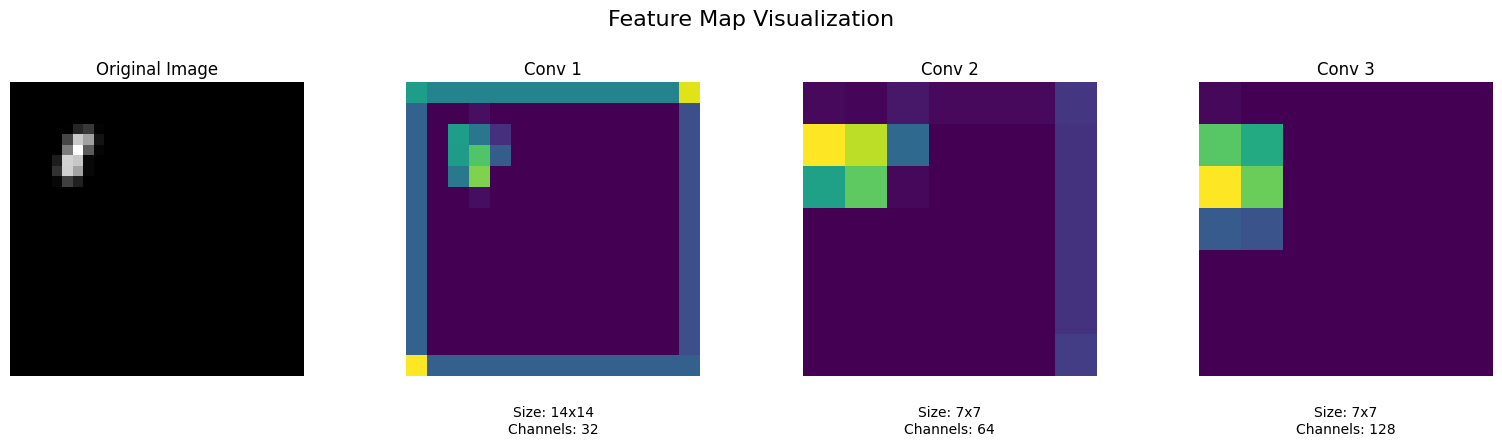

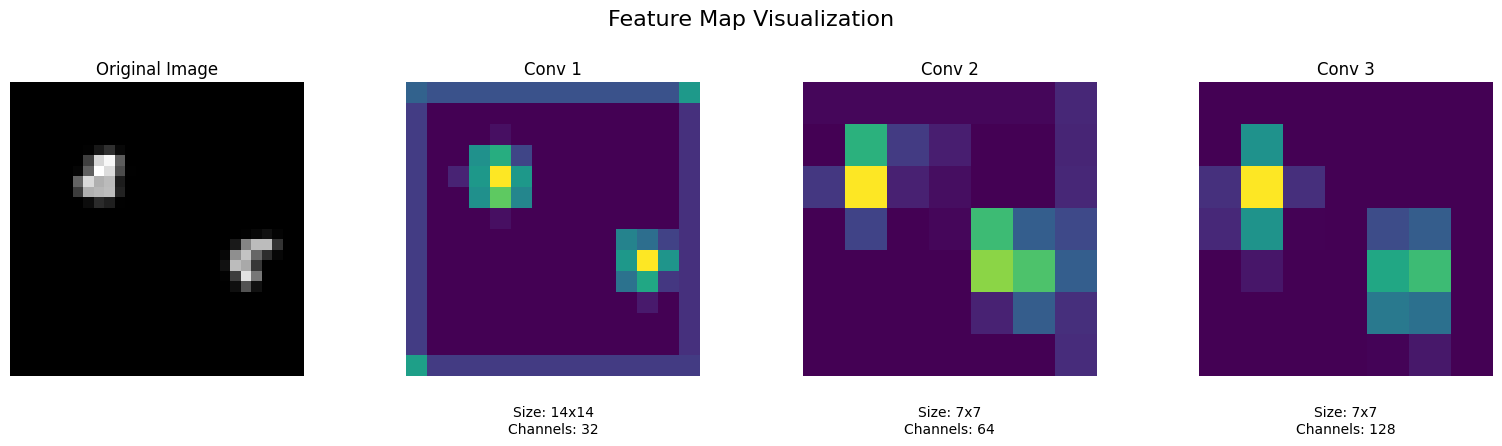

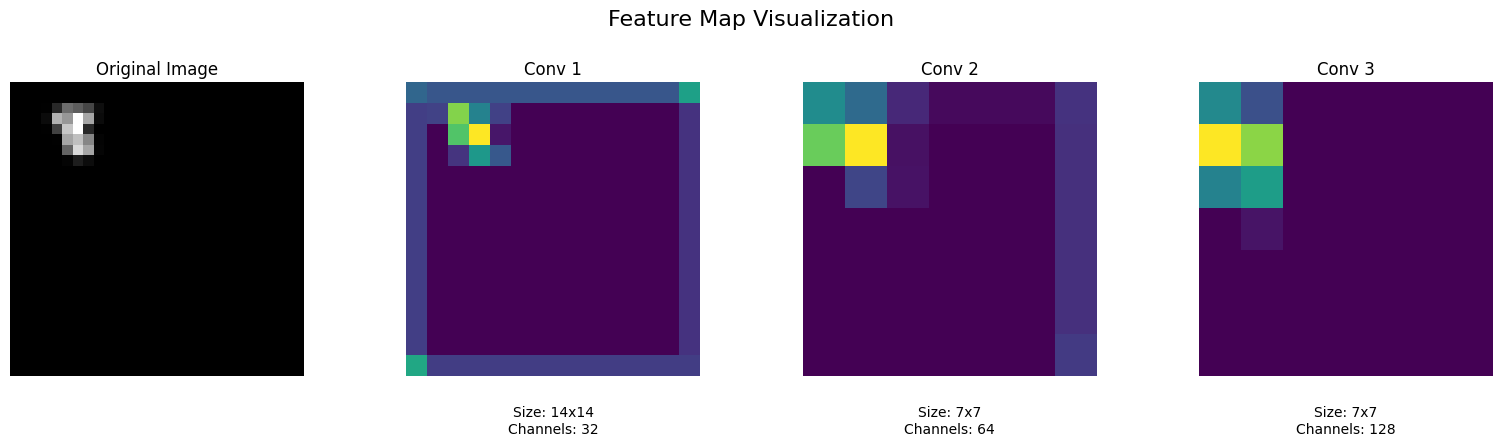

In [10]:
if config["task"] == "single_label":
    if config["slc"]["do_classification"]:
        print(f"slc classification")
        model = CNN(
            task="classification",
            label_type="single",
            lr=config["slc"]["lr"],
            n_cnn_layers=config["slc"]["n_cnn_layers"],
            optimizer=config["slc"]["optimizer"], 
            save_feature_maps=config["slc"]["save_feature_maps"],
            input_channels=config["slc"]["input_channels"],
            num_classes=config["slc"]["num_classes"],
            kernel_size=config["slc"]["kernel_size"],
            padding=config["slc"]["padding"]
        ).to(device)
    elif config["slc"]["do_classification"] == False:
        print(f"slc regression")
        model = CNN(
            task="regression",
            label_type="single",
            lr=config["slc"]["lr"],
            n_cnn_layers=config["slc"]["n_cnn_layers"],
            optimizer=config["slc"]["optimizer"], 
            save_feature_maps=config["slc"]["save_feature_maps"],
            input_channels=config["slc"]["input_channels"],
            num_classes=config["slc"]["num_classes"],
            kernel_size=config["slc"]["kernel_size"],
            padding=config["slc"]["padding"]
        ).to(device)
elif config["task"] == "multi_label":
    if config["mlc"]["do_classification"]:
        print(f"mlc classification")
        model = CNN(
            task="classification",
            label_type="multi",
            lr=config["mlc"]["lr"],
            n_cnn_layers=config["mlc"]["n_cnn_layers"],
            optimizer=config["mlc"]["optimizer"], 
            save_feature_maps=config["mlc"]["save_feature_maps"],
            input_channels=config["mlc"]["input_channels"],
            num_classes=config["mlc"]["num_classes"],
            kernel_size=config["mlc"]["kernel_size"],
            padding=config["mlc"]["padding"]
        ).to(device)
    elif config["mlc"]["do_classification"] == False:
        print(f"mlc regression")
        model = CNN(
            task="regression",
            label_type="multi",
            lr=config["mlc"]["lr"],
            n_cnn_layers=config["mlc"]["n_cnn_layers"],
            optimizer=config["mlc"]["optimizer"], 
            save_feature_maps=config["mlc"]["save_feature_maps"],
            input_channels=config["mlc"]["input_channels"],
            num_classes=config["mlc"]["num_classes"],
            kernel_size=config["mlc"]["kernel_size"],
            padding=config["mlc"]["padding"]
        ).to(device)

if config["wandb_logging"]:
    print(f"Setting up wandb...")
    wandb.login()
    if config["task"] == "multi_label":
        if config["mlc"]["do_classification"]:
            wandb.init(
                project="SMAI-A4",
                name=f"Multi-Label_Classification_CNN",
                entity="vemulasakethreddy_10",
                config=config
            )
        else:
            wandb.init(
                project="SMAI-A4",
                name=f"Multi-Label_Regression_CNN",
                entity="vemulasakethreddy_10",
                config=config
            )
    elif config["task"] == "single_label":
        if config["slc"]["do_classification"]:
            wandb.init(
                project="SMAI-A4",
                name=f"Single-Label_Classification_CNN",
                entity="vemulasakethreddy_10",
                config=config
            )
        else:
            wandb.init(
                project="SMAI-A4",
                name=f"Single-Label_Regression_CNN",
                entity="vemulasakethreddy_10",
                config=config
            )


if config["task"] == "single_label":
    train_CNN(
        model,
        num_epochs=config["slc"]["num_epochs"],
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device
    )
elif config["task"] == "multi_label":
    train_CNN(
        model,
        num_epochs=config["mlc"]["num_epochs"],
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device
    )

results = evaluate_CNN(
    model=model,
    test_dataloader=test_dataloader,
    device=device
)

print(results)

for i in range(3):
    visualize_feature_maps(model, next(iter(train_dataloader))[0][0], device=device, idx=(i + 1))

if config["wandb_logging"]:
    wandb.finish()


## 2.3 Hyperparameter Tuning (10 Marks)

In [ ]:
def tune_slc_classification_CNN():
    l_rate_list = [1e-3, 1e-4]
    dropout_list = [0.05, 0.1, 0.2]
    n_cnn_layers_list = [1, 3]
    optimizer_list = ["SGD", "Adam", "AdamW"]
    results_list = []
    sweep_config = {
        "method": "grid",
        "name": f"slc_classification_CNN",
        "metric": {
            "goal": "maximize",
            "name": "test/accuracy"
        },
        "parameters": {
            "l_rate": {
                "values": l_rate_list
            },
            "dropout": {
                "values": dropout_list 
            },
            "n_cnn_layers": {
                "values": n_cnn_layers_list
            },
            "optimizer": {
                "values": optimizer_list
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep_config,
        project="SMAI-A4"
    )

    def tune_model():
        wandb.init(
            project="SMAI-A4"
        )
        sleep_config=wandb.config
        l_rate = sleep_config.l_rate
        dropout = sleep_config.dropout
        n_cnn_layers = sleep_config.n_cnn_layers
        optimizer = sleep_config.optimizer

        model = CNN(
            task="classification",
            label_type="single",
            lr=l_rate,
            dropout=dropout,
            n_cnn_layers=n_cnn_layers,
            optimizer=optimizer,
            save_feature_maps=False,
            input_channels=config["slc"]["input_channels"],
            num_classes=config["slc"]["num_classes"],
            kernel_size=config["slc"]["kernel_size"],
            padding=config["slc"]["padding"]
        ).to(device)


        train_CNN(model, config["slc"]["num_epochs"], train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device)
        results = evaluate_CNN(model, test_dataloader=test_dataloader, device=device)
        results["lr"] = l_rate
        results["dropout"] = dropout
        results["n_cnn_layers"] = n_cnn_layers
        results["optimizer"] = optimizer
        results["test/loss"] = results["loss"]
        results["test/accuracy"] = results["metric"]

        results_list.append(results)

        wandb.log({
            "lr": l_rate,
            "dropout": dropout,
            "n_cnn_layers": n_cnn_layers,
            "optimizer": optimizer,
            "test/loss": results["loss"],
            "test/accuracy": results["metric"]
        })
    
    wandb.agent(sweep_id=sweep_id, function=tune_model)

    df = pd.DataFrame(results_list)
    df = df.sort_values(by="test/accuracy", ascending=False)
    df = df.reset_index(drop=True)
    print(f"HT: Single Label Classification using CNN")
    print(df.to_string(index=False))
    best_params = df.iloc[0].to_string(index=False)
    print(f"\bBest Model Parameters")
    print(best_params)
    wandb.finish()

def tune_slc_regression_CNN():
    l_rate_list = [1e-3, 1e-4]
    dropout_list = [0.05, 0.1, 0.2]
    n_cnn_layers_list = [1, 3]
    optimizer_list = ["SGD", "Adam", "AdamW"]
    results_list = []
    sweep_config = {
        "method": "grid",
        "name": f"slc_regression_CNN",
        "metric": {
            "goal": "minimize",
            "name": "test/loss"
        },
        "parameters": {
            "l_rate": {
                "values": l_rate_list
            },
            "dropout": {
                "values": dropout_list 
            },
            "n_cnn_layers": {
                "values": n_cnn_layers_list
            },
            "optimizer": {
                "values": optimizer_list
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep_config,
        project="SMAI-A4"
    )

    def tune_model():
        wandb.init(
            project="SMAI-A4"
        )
        sleep_config=wandb.config
        l_rate = sleep_config.l_rate
        dropout = sleep_config.dropout
        n_cnn_layers = sleep_config.n_cnn_layers
        optimizer = sleep_config.optimizer

        model = CNN(
            task="regression",
            label_type="single",
            lr=l_rate,
            dropout=dropout,
            n_cnn_layers=n_cnn_layers,
            optimizer=optimizer,
            save_feature_maps=False,
            input_channels=config["slc"]["input_channels"],
            num_classes=config["slc"]["num_classes"],
            kernel_size=config["slc"]["kernel_size"],
            padding=config["slc"]["padding"]
        ).to(device)

        train_CNN(model, config["slc"]["num_epochs"], train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device)
        results = evaluate_CNN(model, test_dataloader=test_dataloader, device=device)
        results["lr"] = l_rate
        results["dropout"] = dropout
        results["n_cnn_layers"] = n_cnn_layers
        results["optimizer"] = optimizer
        results["test/loss"] = results["loss"]
        results["test/accuracy"] = results["metric"]

        results_list.append(results)

        wandb.log({
            "lr": l_rate,
            "dropout": dropout,
            "n_cnn_layers": n_cnn_layers,
            "optimizer": optimizer,
            "test/loss": results["loss"],
            "test/accuracy": results["metric"]
        })
    
    wandb.agent(sweep_id=sweep_id, function=tune_model)

    df = pd.DataFrame(results_list)
    df = df.sort_values(by="test/loss", ascending=True)
    df = df.reset_index(drop=True)
    print(f"HT: Single Label Regression using CNN")
    print(df.to_string(index=False))
    best_params = df.iloc[0].to_string(index=False)
    print(f"\bBest Model Parameters")
    print(best_params)
    wandb.finish()

tune_slc_classification_CNN()
tune_slc_regression_CNN()

## 2.4 Feature map Visualization (10 Marks)

In [ ]:

def visualize_feature_maps(model: CNN, sample_input: torch.Tensor, device: torch.device, idx: int, max_channels_per_layer: int = 1):
    """
    Visualizes original image and one feature map from each convolutional layer in a single row
    
    Args:
        model: CNN model
        sample_input: Single input image tensor
        device: Computing device (CPU/GPU)
        max_channels_per_layer: Maximum number of channels to display per layer
    """
    model.eval()
    
    with torch.no_grad():
        # Get feature maps
        _ = model(sample_input.unsqueeze(0).to(device))
    
    # Calculate number of plots needed (original + feature maps)
    n_plots = len(model.features_maps) + 1
    
    # Create figure with a single row
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
    fig.suptitle('Feature Map Visualization', fontsize=16, y=1.05)
    
    # Plot original image
    axes[0].imshow(sample_input.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot first channel of feature map for each conv layer
    for layer_idx, feature_map in enumerate(model.features_maps):
        # Get first channel of the feature map
        feature_map = feature_map.squeeze()
        if len(feature_map.shape) == 3:  # If multiple channels, take the first one
            feature_map = feature_map[0]
            
        # Plot the feature map
        im = axes[layer_idx + 1].imshow(feature_map.cpu(), cmap='viridis')
        axes[layer_idx + 1].set_title(f'Conv {layer_idx + 1}')
        axes[layer_idx + 1].axis('off')
        
        # Add size information at the bottom
        axes[layer_idx + 1].text(
            0.5, -0.1, 
            f'Size: {feature_map.shape[0]}x{feature_map.shape[1]}\nChannels: {model.features_maps[layer_idx].size(1)}',
            ha='center',
            va='top',
            transform=axes[layer_idx + 1].transAxes
        )
    
    plt.tight_layout()
    plt.savefig(f"conv_layers_{idx}.png")
    plt.show()

We can make some observations about the features learned at different layers of the CNN:

1. **Initial Convolutional Layers (Conv 1):**
   - The first convolutional layer primarily detects simple edges and basic shapes. The feature maps show small, localized activations, indicating that the model is identifying basic components such as edges or boundaries of the digits. This is typical in early layers, as they usually capture low-level features.

2. **Intermediate Convolutional Layers (Conv 2):**
   - In the second convolutional layer, the feature maps start focusing on more specific parts of the digits. The activations are more refined, capturing slightly more complex shapes and potentially overlapping features of multiple digits in the image. This layer may capture parts of each digit, recognizing key regions rather than full digit shapes.

3. **Deeper Convolutional Layers (Conv 3):**
   - By the third convolutional layer, the model is likely capturing higher-level, more abstract features. The feature maps show fewer, more concentrated areas of activation, possibly highlighting distinctive parts or unique combinations of edges that help differentiate between multiple digits in the image. This layer may help the model generalize by combining the simpler features detected in earlier layers into more meaningful, larger patterns.

These observations suggest that the CNN is progressively learning from simple to complex patterns. The initial layers focus on foundational shapes, which are combined in subsequent layers to distinguish between digits in more detail. This layered approach helps the CNN to handle the overlapping digits in Multi-MNIST effectively for classification.

# Multi-Label Classification (30 Marks)

Note: set task: "multi_label" in `config.yaml`

## 3.1 Data Loading and Preprocessing (5 Marks)

In [ ]:
def get_one_hot_encoding(label: List[int], num_classes: int=10):
    encoding = torch.zeros(num_classes)
    for digit in label:
        encoding[digit] = 1
    return encoding

def parse_folder_name(folder_name: str):
    list_format = [int(d) for d in str(folder_name)]
    if config["task"] == "single_label":
        if folder_name == "0":
            return []
        else:
            return [(len(list_format))]
    elif config["task"] == "multi_label":
        if folder_name == "0":
            return []
        else:
            return list_format


def load_mnist_data(path_to_data: str):
    data = []

    for folder_name in os.listdir(path_to_data):
        folder_path = os.path.join(path_to_data, folder_name)
        if not os.path.isdir(folder_path):
            continue

        digits = parse_folder_name(folder_name)

        if config["task"] == "single_label":
            label = get_one_hot_encoding(digits, num_classes=config["slc"]["num_classes"])
        elif config["task"] == "multi_label":
            label = get_one_hot_encoding(digits, num_classes=config["mlc"]["num_classes"])

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            data.append((img_path, label))

    return data
    
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((config["input_size"], config["input_size"])),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
    
train_dataset = MultiMNISTDataset(split="train", transform=transform)
val_dataset = MultiMNISTDataset(split="val", transform=transform)
test_dataset = MultiMNISTDataset(split="test", transform=transform)

if config["task"] == "single_label":
    train_dataloader = DataLoader(train_dataset, batch_size=config["slc"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["slc"]["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["slc"]["batch_size"], shuffle=True)
elif config["task"] == "multi_label":
    train_dataloader = DataLoader(train_dataset, batch_size=config["mlc"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["mlc"]["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["mlc"]["batch_size"], shuffle=True)


## 3.2 Implement the MultiLabelCNN Class (15 marks)

In [ ]:
class CNN(nn.Module):
    def __init__(
            self,
            task: str,
            label_type: str,
            lr: float=1e-4,
            dropout: float=0.1,
            n_cnn_layers: int=3,
            optimizer: str="AdamW",
            save_feature_maps: bool=False,
            input_channels: int=1,
            num_classes: int=3,
            kernel_size: int=3,
            padding: int=1
    ):
        super(CNN, self).__init__()
        self.lr = lr
        self.task = task
        self.label_type = label_type
        self.save_feature_maps = save_feature_maps
        # self.feature_maps = defaultdict(list) if save_feature_maps else None
        self.features_maps: list = []

        current_size = config["input_size"]  # Initial image size
        current_channels = input_channels
        
        self.layers = nn.ModuleList()
        
        for i in range(n_cnn_layers):
            out_channels = current_channels * 2 if i > 0 else 32
            self.layers.append(
                nn.Conv2d(
                    current_channels,
                    out_channels, 
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
            current_size = (current_size + 2 * padding - kernel_size) // 1 + 1
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU())            
            if current_size // 2 >= 1:
                self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                current_size //= 2
            self.layers.append(nn.Dropout(dropout))
            current_channels = out_channels
            print(f"Layer {i+1} output size: {current_size}x{current_size}, channels: {current_channels}")

        self.feature_size = current_channels * current_size * current_size
        print(f"Feature size before FC layer: {self.feature_size}")

        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        if self.task == "classification":
            if self.label_type == "multi":
                self.output_layer = nn.Sequential(
                    nn.Linear(512, num_classes),
                    nn.Sigmoid()
                )
            else:  # single
                self.output_layer = nn.Sequential(
                    nn.Linear(512, num_classes),
                    nn.Softmax(dim=1)
                )
        else:  # regression
            self.output_layer = nn.Sequential(
                nn.Linear(512, num_classes),
                nn.Identity()
            )

        if optimizer.lower() == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer.lower() == "adamw":
            self.optimizer = torch.optim.AdamW(self.parameters(), lr=lr)
        elif optimizer.lower() == "sgd":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        elif optimizer.lower() == "adagrad":
            self.optimizer = torch.optim.Adagrad(self.parameters(), lr=lr)

        if self.task == "classification":
            if self.label_type == "single":
                self.criterion = nn.CrossEntropyLoss()
            else:  # multi
                self.criterion = nn.BCELoss()
        else:  # regression
            self.criterion = nn.MSELoss()

    def _save_feature_map(self, x: torch.Tensor, layer_name: str):
        if self.save_feature_maps:
            self.feature_maps[layer_name].append(x.detach().cpu())

    def forward(self, x: torch.Tensor):
        if self.save_feature_maps:
            self.features_maps = []
            
        # Conv layers
        for i, layer in enumerate(self.layers):
            x = layer(x)

            if i % 4 == 0 and i != 0 and self.save_feature_maps:
                self.features_maps.append(x.detach().cpu())

        # # Flatten
        x = x.view(-1, self.feature_size)
        
        # # FC layers
        x = self.fc_layers(x)
        
        # # Output layer
        x = self.output_layer(x)
        
        return x

## 3.2.3 

Yes, this model requires an additional activation function after the last linear layer for multi-label classification but not for single-label classification. Reasons:

### Multi-label Classification
In multi-label classification, each class is considered independently. The model needs to output a probability for each class, typically between 0 and 1, representing the likelihood of the presence of each label. To achieve this, a `Sigmoid` activation is used after the last linear layer because it transforms each output into a value between 0 and 1. Each output neuron operates independently, which is essential for multi-label classification, where more than one label can be positive simultaneously.

The choice of `Sigmoid` in multi-label classification is critical because:
- It squashes the output to a range of [0, 1], suitable for interpreting each class as an independent probability.
- It allows each label to be classified independently, enabling the model to output multiple positive labels simultaneously.

### Single-label Classification
In single-label classification, the model must predict a single label out of multiple classes. Here, `Softmax` is used after the final linear layer because it normalizes the outputs across all classes, ensuring that their sum equals 1. Each output is interpreted as the probability of each class being the true label. `Softmax` is suitable for this scenario because it highlights the most probable class, which is necessary for exclusive single-label predictions.

### Regression
In regression tasks, the output does not represent probabilities but rather continuous values that can span any range (negative or positive). Therefore, it’s common not to apply an activation function after the last linear layer for regression. Adding a `Sigmoid` or `Softmax` would restrict the output range, which could prevent the model from fitting the data properly in continuous target spaces.

### Summary
- **Multi-label classification**: Use `Sigmoid` to produce independent probabilities for each class.
- **Single-label classification**: Use `Softmax` to produce a probability distribution across all classes.
- **Regression**: No activation, as the output needs to cover a continuous range.

## 3.3 Hyperparameter Tuning (10 Marks)

In [ ]:
def tune_mlc_classification_CNN():
    l_rate_list = [1e-3, 1e-4]
    dropout_list = [0.1, 0.2]
    n_cnn_layers_list = [3, 5]
    optimizer_list = ["SGD", "Adam", "AdamW"]
    results_list = []
    sweep_config = {
        "method": "grid",
        "name": f"mlc_classification_CNN",
        "metric": {
            "goal": "maximize",
            "name": "test/exact_match_accuracy"
        },
        "parameters": {
            "l_rate": {
                "values": l_rate_list
            },
            "dropout": {
                "values": dropout_list 
            },
            "n_cnn_layers": {
                "values": n_cnn_layers_list
            },
            "optimizer": {
                "values": optimizer_list
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep_config,
        project="SMAI-A4"
    )

    def tune_model():
        wandb.init(
            project="SMAI-A4"
        )
        sleep_config=wandb.config
        l_rate = sleep_config.l_rate
        dropout = sleep_config.dropout
        n_cnn_layers = sleep_config.n_cnn_layers
        optimizer = sleep_config.optimizer

        model = CNN(
            task="classification",
            label_type="multi",
            lr=l_rate,
            dropout=dropout,
            n_cnn_layers=n_cnn_layers,
            optimizer=optimizer,
            save_feature_maps=False,
            input_channels=config["mlc"]["input_channels"],
            num_classes=config["mlc"]["num_classes"],
            kernel_size=config["mlc"]["kernel_size"],
            padding=config["mlc"]["padding"]
        ).to(device)

        train_CNN(model, config["mlc"]["num_epochs"], train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device)
        results = evaluate_CNN(model, test_dataloader=test_dataloader, device=device)
        results["lr"] = l_rate
        results["dropout"] = dropout
        results["n_cnn_layers"] = n_cnn_layers
        results["optimizer"] = optimizer
        results["test/loss"] = results["loss"]
        results["test/accuracy"] = results["match_accuracy"]
        results["test/exact_match_accuracy"] = results["exact_match_accuracy"]

        results_list.append(results)

        wandb.log({
            "lr": l_rate,
            "dropout": dropout,
            "n_cnn_layers": n_cnn_layers,
            "optimizer": optimizer,
            "test/loss": results["loss"],
            "test/accuracy": results["match_accuracy"],
            "test/exact_match_accuracy": results["exact_match_accuracy"]
        })
    
    wandb.agent(sweep_id=sweep_id, function=tune_model)

    df = pd.DataFrame(results_list)
    df = df.sort_values(by="test/accuracy", ascending=False)
    df = df.reset_index(drop=True)
    print(f"HT: Multi Label Classification using CNN")
    print(df.to_string(index=False))
    best_params = df.iloc[0].to_string(index=False)
    print(f"\bBest Model Parameters")
    print(best_params)
    wandb.finish()

def tune_mlc_regression_CNN():
    l_rate_list = [5e-4, 1e-4]
    dropout_list = [0.1, 0.2]
    n_cnn_layers_list = [3, 5]
    optimizer_list = ["SGD", "Adam", "AdamW"]
    results_list = []
    sweep_config = {
        "method": "grid",
        "name": f"mlc_regression_CNN",
        "metric": {
            "goal": "minimize",
            "name": "test/loss"
        },
        "parameters": {
            "l_rate": {
                "values": l_rate_list
            },
            "dropout": {
                "values": dropout_list 
            },
            "n_cnn_layers": {
                "values": n_cnn_layers_list
            },
            "optimizer": {
                "values": optimizer_list
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep_config,
        project="SMAI-A4"
    )

    def tune_model():
        wandb.init(
            project="SMAI-A4"
        )
        sleep_config=wandb.config
        l_rate = sleep_config.l_rate
        dropout = sleep_config.dropout
        n_cnn_layers = sleep_config.n_cnn_layers
        optimizer = sleep_config.optimizer

        model = CNN(
            task="regression",
            label_type="multi",
            lr=l_rate,
            dropout=dropout,
            n_cnn_layers=n_cnn_layers,
            optimizer=optimizer,
            save_feature_maps=False,
            input_channels=config["mlc"]["input_channels"],
            num_classes=config["mlc"]["num_classes"],
            kernel_size=config["mlc"]["kernel_size"],
            padding=config["mlc"]["padding"]
        ).to(device)

        train_CNN(model, config["mlc"]["num_epochs"], train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device)
        results = evaluate_CNN(model, test_dataloader=test_dataloader, device=device)
        results["lr"] = l_rate
        results["dropout"] = dropout
        results["n_cnn_layers"] = n_cnn_layers
        results["optimizer"] = optimizer
        results["test/loss"] = results["loss"]
        results["test/accuracy"] = results["metric"]

        results_list.append(results)

        wandb.log({
            "lr": l_rate,
            "dropout": dropout,
            "n_cnn_layers": n_cnn_layers,
            "optimizer": optimizer,
            "test/loss": results["loss"],
            "test/accuracy": results["metric"]
        })
    
    wandb.agent(sweep_id=sweep_id, function=tune_model)

    df = pd.DataFrame(results_list)
    df = df.sort_values(by="test/loss", ascending=True)
    df = df.reset_index(drop=True)
    print(f"HT: Multi Label Regression using CNN")
    print(df.to_string(index=False))
    best_params = df.iloc[0].to_string(index=False)
    print(f"\bBest Model Parameters")
    print(best_params)
    wandb.finish()

tune_mlc_classification_CNN()
tune_mlc_regression_CNN()